In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import numpy as np

In [ ]:
#bird_strike_df = pd.read_excel('/content/drive/MyDrive/bird/combined_bird_data.xlsx')
#combined_df = pd.read_csv("/content/drive/MyDrive/merged_data_5_years_new.csv")
combined_df = pd.read_csv("/content/drive/MyDrive/data/combined_all")

<ipython-input-9-5e5de7e3e964>:3: DtypeWarning: Columns (60,134) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv("/content/drive/MyDrive/data/combined_all")


Data cleaning

In [ ]:
nan_counts = combined_df.isna().sum()
print(nan_counts)

YEAR            0
MONTH           0
DAY_OF_MONTH    0
DAY_OF_WEEK     0
FL_DATE         0
               ..
SOURCE          0
PERSON          0
LUPDATE         0
IMAGE           0
TRANSFER        0
Length: 149, dtype: int64


FEATURE_ENGINEERING

In [ ]:
final_df = pd.DataFrame()
final_df["IsDelay"] = np.where((combined_df['DEP_DEL15'] == 1) | (combined_df['ARR_DELAY'] == 1), 1, 0)

In [ ]:
final_df["IsDelay"].head()

0    0
1    0
2    0
3    0
4    1
Name: IsDelay, dtype: int64

In [ ]:
combined_df["ARR_DELAY_NEW"].head()
combined_df["DEP_DELAY_NEW"].head()

0      0.0
1      0.0
2      0.0
3      0.0
4    534.0
Name: DEP_DELAY_NEW, dtype: float64

In [ ]:
combined_df["DISTANCE_y"]

0        2.0
1        2.0
2        0.0
3        0.0
4        0.0
        ... 
10982    0.0
10983    0.0
10984    0.0
10985    0.0
10986    0.0
Name: DISTANCE_y, Length: 10987, dtype: float64

In [ ]:
final_df["Distance"] = combined_df["DISTANCE_x"]
final_df["AirTime"] = combined_df["ARR_TIME"]
final_df["AOS"] = combined_df["AOS"]

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
final_df["StrikePhase"] = label_encoder.fit_transform(combined_df['PHASE_OF_FLIGHT'])

In [ ]:
X = final_df.drop(columns=["IsDelay"])
Y = final_df["IsDelay"]

Model Training

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8240 entries, 9002 to 2732
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Distance     8240 non-null   float64
 1   AirTime      8240 non-null   float64
 2   AOS          8240 non-null   float64
 3   StrikePhase  8240 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 321.9 KB


In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model.score(X_test,y_test)

0.7047688387331634

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest model:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy of Random Forest model: 0.7033127047688388
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      1936
           1       0.50      0.36      0.42       811

    accuracy                           0.70      2747
   macro avg       0.63      0.60      0.61      2747
weighted avg       0.68      0.70      0.69      2747



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel='linear', C=1.0, random_state=0)

svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM model:", accuracy_svm)
print("Classification Report for SVM:\n", classification_report(y_test, y_pred_svm))


Accuracy of SVM model: 0.7047688387331634
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      1936
           1       0.00      0.00      0.00       811

    accuracy                           0.70      2747
   macro avg       0.35      0.50      0.41      2747
weighted avg       0.50      0.70      0.58      2747



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with optimized Random Forest:", accuracy)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score: 0.74
Accuracy with optimized Random Forest: 0.740444120859119


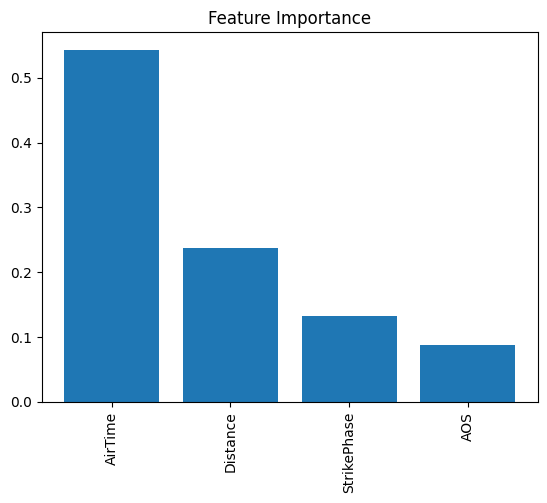

In [ ]:
import matplotlib.pyplot as plt

feature_importances = rf_best.feature_importances_
features = X_train.columns

indices = np.argsort(feature_importances)[::-1]

names = [features[i] for i in indices]


plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()
